In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed
from dask.distributed import Client, progress
import dask
import dask.array as da
import dask.dataframe as dd
import joblib
import pandas as pd
import spacy
from sklearn.decomposition import PCA
from scipy import stats

import warnings
#warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
sns.set(style='whitegrid', palette='colorblind', color_codes=True, font_scale=2)

In [2]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:34231 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 84.47 GB


In [4]:
df = dd.read_parquet('cars_cleaned.parquet')

In [5]:
df.head()

,body_type,combine_fuel_economy,daysonmarket,engine_type,franchise_dealer,fuel_type,horsepower,is_cpo,make_name,maximum_seating,mileage,price,transmission,wheel_system,target,age
vin,,,,,,,,,,,,,,,,
19UDE2F30GA022490,Sedan,29.950,11,I4,0,Gasoline,201.000,0,Acura,5,29903.000,16400.000,Dual Clutch,FWD,1,5
19UDE2F30HA008008,Sedan,29.500,58,I4,1,Gasoline,201.000,1,Acura,5,14794.000,18784.000,A,FWD,0,4
19UDE2F30HA008509,Sedan,29.500,159,I4,0,Gasoline,201.000,0,Acura,5,47370.000,12500.000,A,FWD,0,4
19UDE2F30HA008932,Sedan,29.500,122,I4,1,Gasoline,201.000,0,Acura,5,34055.000,16700.000,Dual Clutch,FWD,0,4
19UDE2F30HA011751,Sedan,29.500,20,I4,1,Gasoline,201.000,0,Acura,5,36302.000,18000.000,A,FWD,0,4


In [9]:
df = df.persist()

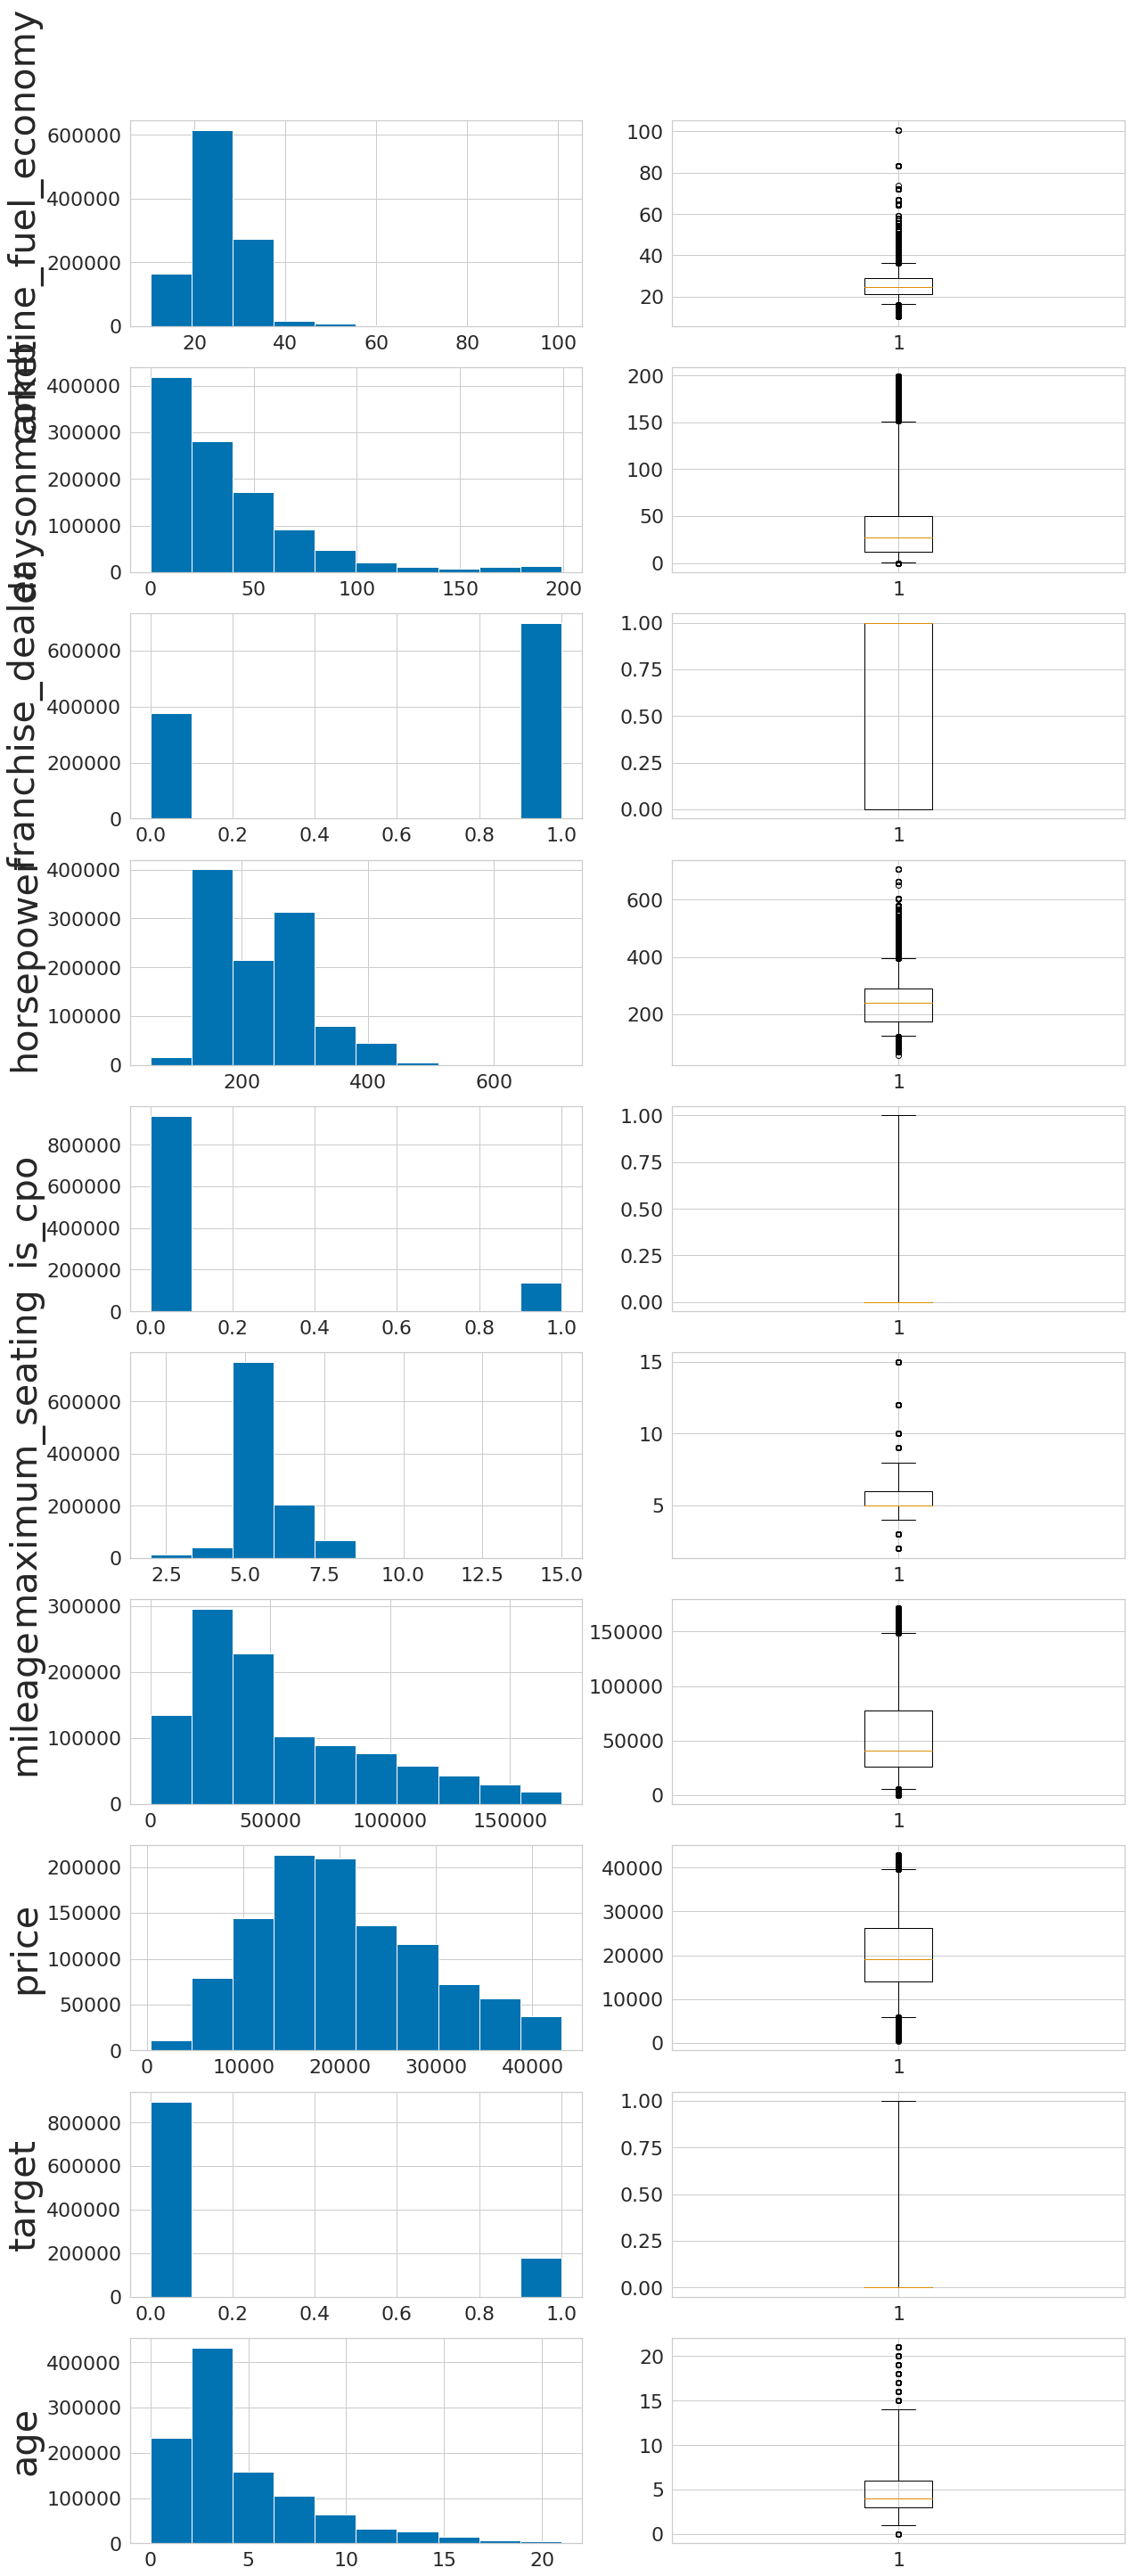

In [10]:
plot_hist_boxplot(df.select_dtypes(include='number'))

<AxesSubplot:title={'center':'Heatmap'}>

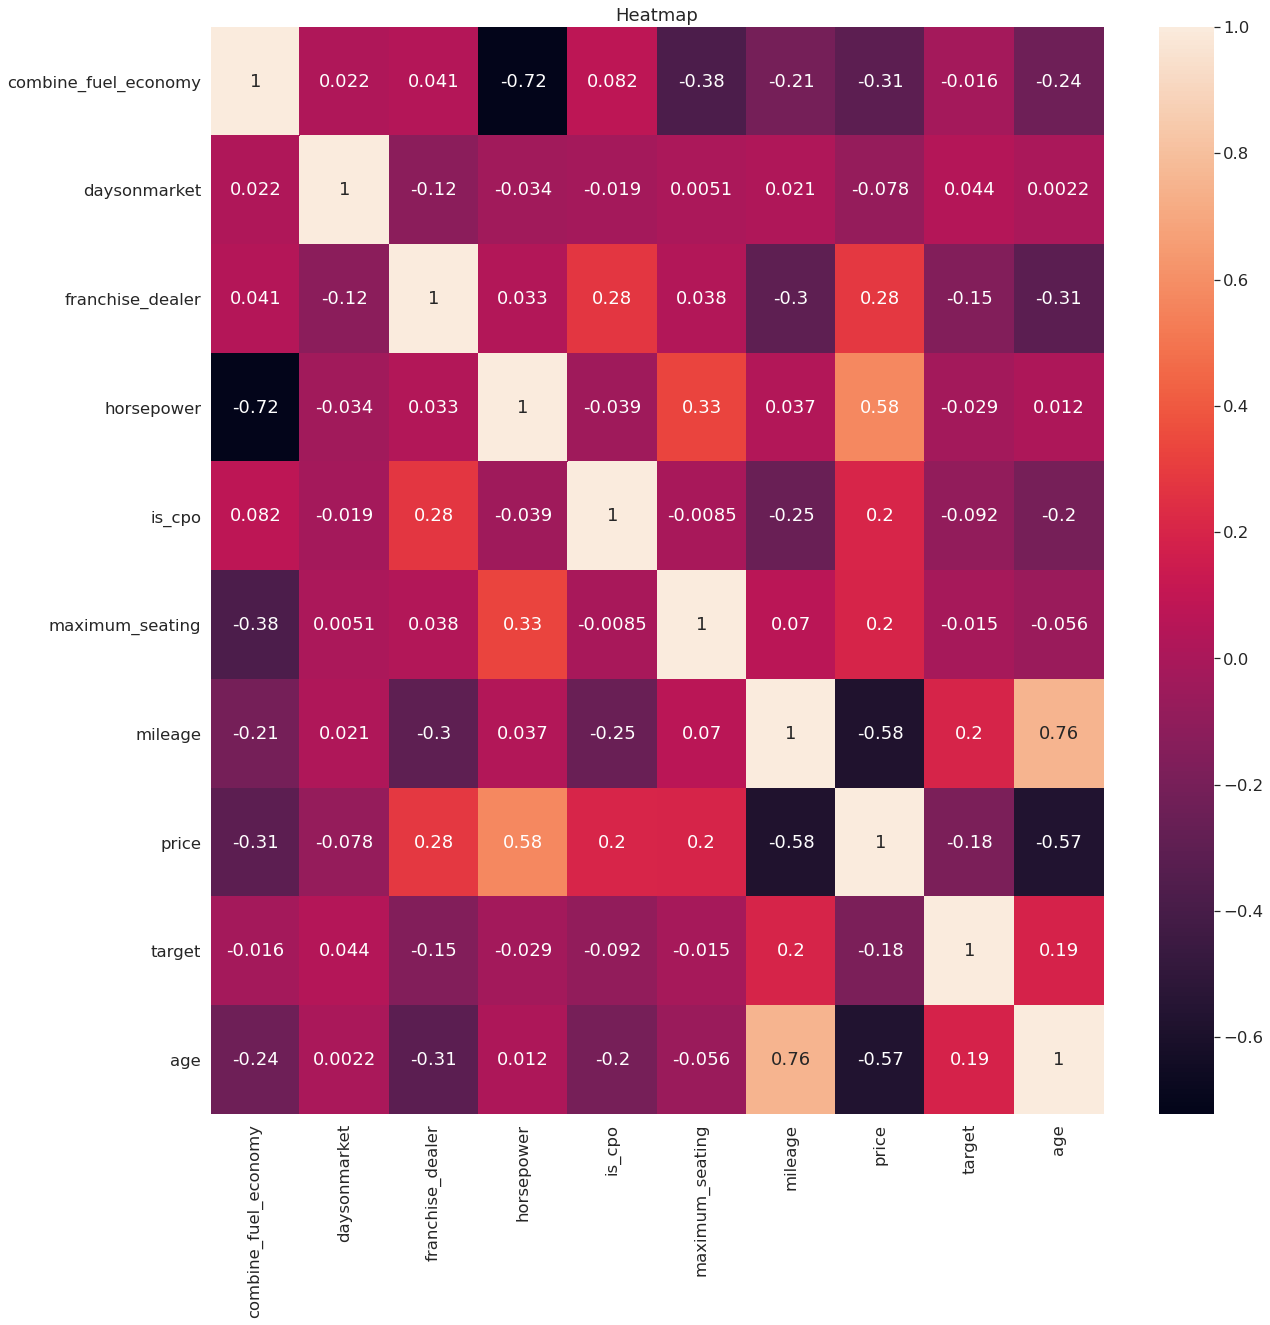

In [11]:
# Plot a heatmap
corr_map = df.corr()
sns.set(font_scale=1.5)

plt.figure(figsize=(20,20))
plt.title('Heatmap')
sns.heatmap(corr_map.compute(), annot=True, )

<Figure size 1440x1440 with 0 Axes>

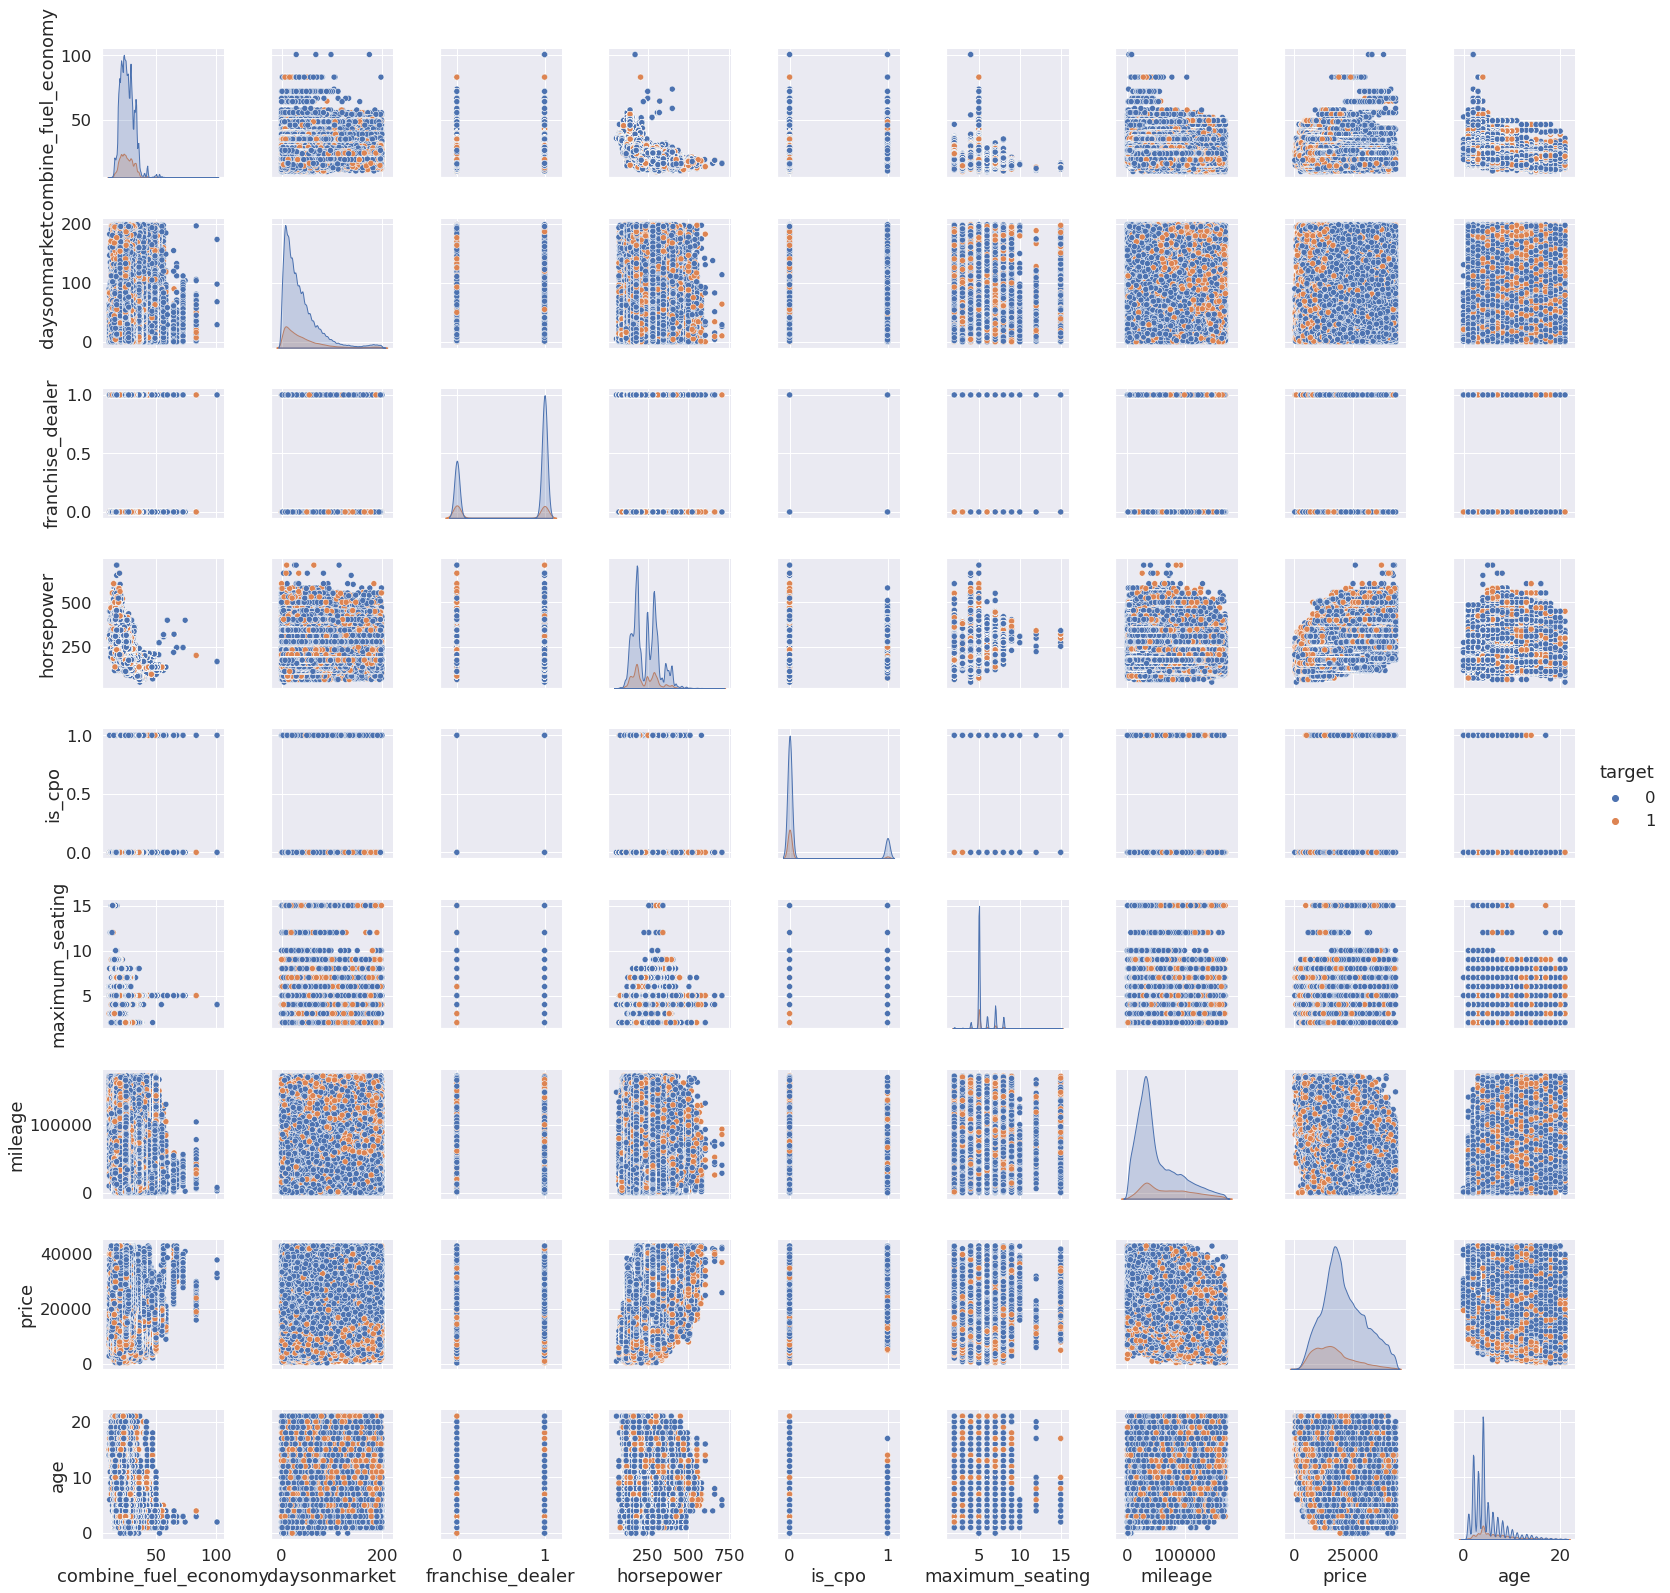

In [12]:
plt.figure(figsize=(20,20))
sns.pairplot(df.compute(), hue='target')

I can see from both the heatmap and the pairplots that none of the variables are a particularly strong indicator of the target. This is a problem and indicates that these variables may not contain the information that I need in order to make accurate predictions.

One thing that is particularly surprising is that there is almost no relationship between certified pre owned and the garget. I would have assumed that cars with problematic histories would be less likely to be certified.


However price has stronger relatinships withing the data. Unsurprisingly mileage is the strongest indicator here. Price also clearly follows a linear trend for horsepower and age. 

There are some concerns about multicolinearity here with age and mileage. 

In [13]:
# Encode Categorical variables
from dask_ml.preprocessing import DummyEncoder
de = DummyEncoder()

df = df.categorize()

w_dummies = de.fit_transform(df)

In [14]:
pca = PCA(n_components=2)

pca_2d = pca.fit_transform(w_dummies.compute())

Text(0.5, 1.0, 'PCA Representation of the Data')

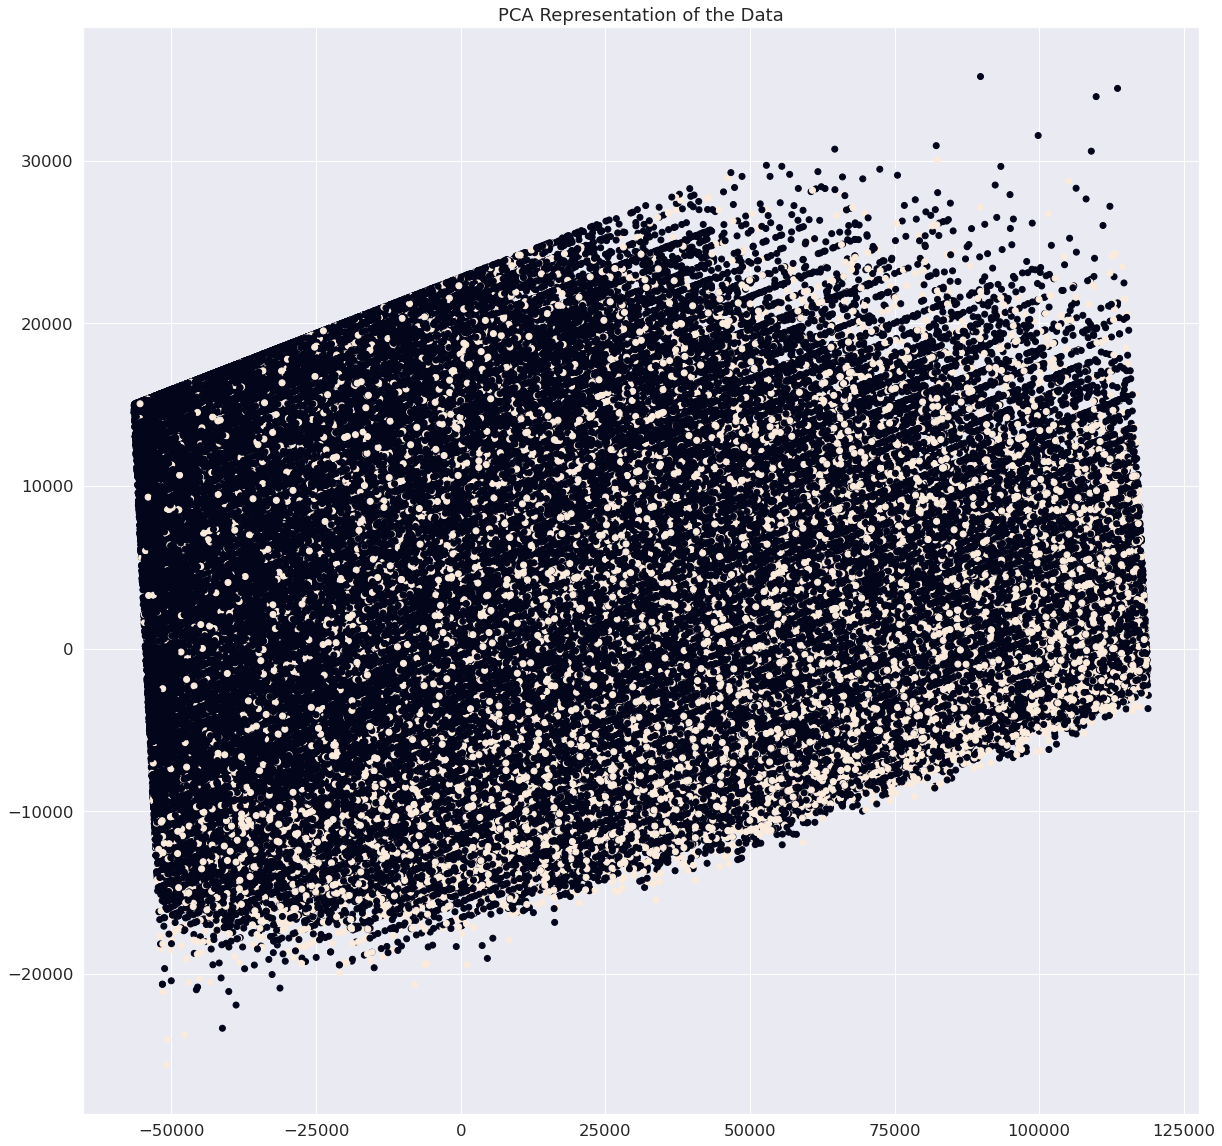

In [15]:
# Lets look at the structure of the data and see if there are any obvious segments.

plt.figure(figsize=(20,20))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=w_dummies['target'])
plt.title('PCA Representation of the Data')

In [16]:
# Is there a statisticaly significant difference in price between the target population and not?

stats.ttest_ind(df[df['target'] == 0]['price'].compute(), df[df['target'] == 1]['price'].compute())

Ttest_indResult(statistic=193.88610614899173, pvalue=0.0)

In [17]:
# Lets check the confidence interval



Text(0.5, 1.0, 'Price Distribution of Cars with and without Negative History Reports')

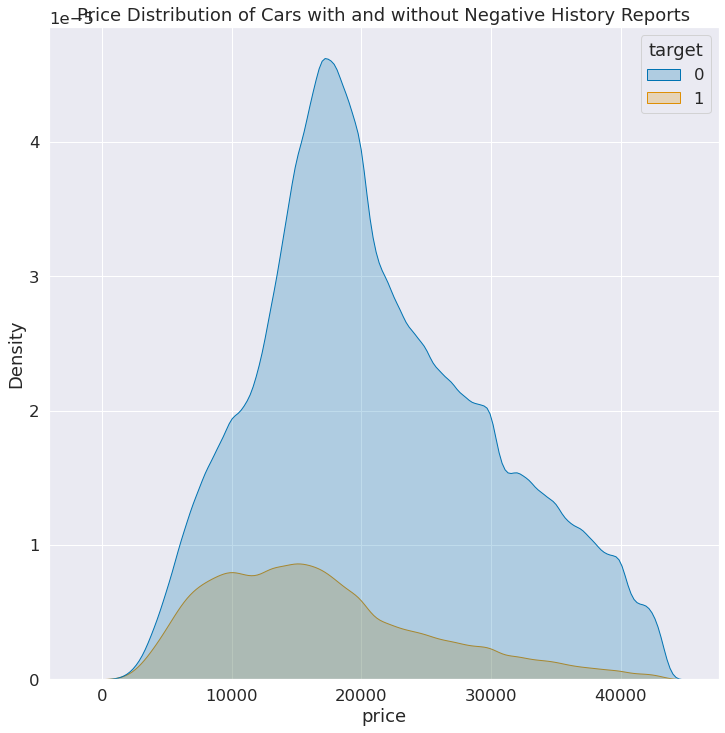

In [18]:
plt.figure(figsize=(12,12))
sns.kdeplot(
    'price'
    , hue='target', shade=True
    , palette = 'colorblind', legend=True
    , data=df)
plt.title('Price Distribution of Cars with and without Negative History Reports')

Text(0.5, 1.0, 'Age Distribution of Cars with and without Negative History Reports')

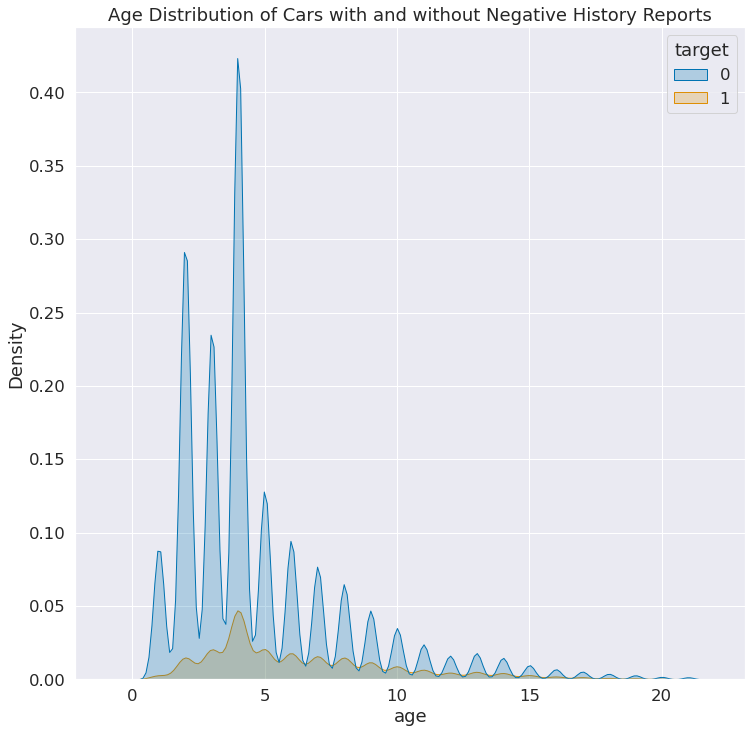

In [19]:
plt.figure(figsize=(12,12))
sns.kdeplot(
    'age'
    , hue='target', shade=True
    , palette = 'colorblind', legend=True
    , data=df)
plt.title('Age Distribution of Cars with and without Negative History Reports')

In [20]:
client.close()